In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Upload the data
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalac', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
df = pd.read_csv('processed.cleveland.data', names = column_names, na_values = '?')
df.fillna(df.median(), inplace = True) # Median imputation

age = df['age'] # age in years
sex = df['sex'] # 1: male, 0: female
cp = df['cp'] # 1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic
trestbps = df['trestbps'] # resting blood pressure in mm Hg
chol = df['chol'] # serum cholestoral in mg/dl
fbs = df['fbs'] # 1: fasting blood sugar > 120 mg/dl, 0: fasting blood sugar <= 120 mg/dl
restecg = df['restecg'] # 0: normal, 1: having ST-T wave abnormality, 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
thalac = df['thalac'] # maximum heart rate achieved
exang = df['exang'] # 1: exercise induced angina, 0: no exercise induced angina
oldpeak = df['oldpeak'] # ST depression induced by exercise relative to rest
slope = df['slope'] # 1: upsloping, 2: flat, 3: downsloping
ca = df['ca'] # number of major vessels (0-3) colored by flourosopy
thal = df['thal'] # 3: normal, 6: fixed defect, 7: reversable defect
num = df['num'] # diagnosis of heart disease (angiographic disease status), 0: < 50% diameter narrowing, 1: > 50% diameter narrowing

print(df)

      age  sex   cp  trestbps   chol  fbs  restecg  thalac  exang  oldpeak  \
0    63.0  1.0  1.0     145.0  233.0  1.0      2.0   150.0    0.0      2.3   
1    67.0  1.0  4.0     160.0  286.0  0.0      2.0   108.0    1.0      1.5   
2    67.0  1.0  4.0     120.0  229.0  0.0      2.0   129.0    1.0      2.6   
3    37.0  1.0  3.0     130.0  250.0  0.0      0.0   187.0    0.0      3.5   
4    41.0  0.0  2.0     130.0  204.0  0.0      2.0   172.0    0.0      1.4   
..    ...  ...  ...       ...    ...  ...      ...     ...    ...      ...   
298  45.0  1.0  1.0     110.0  264.0  0.0      0.0   132.0    0.0      1.2   
299  68.0  1.0  4.0     144.0  193.0  1.0      0.0   141.0    0.0      3.4   
300  57.0  1.0  4.0     130.0  131.0  0.0      0.0   115.0    1.0      1.2   
301  57.0  0.0  2.0     130.0  236.0  0.0      2.0   174.0    0.0      0.0   
302  38.0  1.0  3.0     138.0  175.0  0.0      0.0   173.0    0.0      0.0   

     slope   ca  thal  num  
0      3.0  0.0   6.0    0  
1    

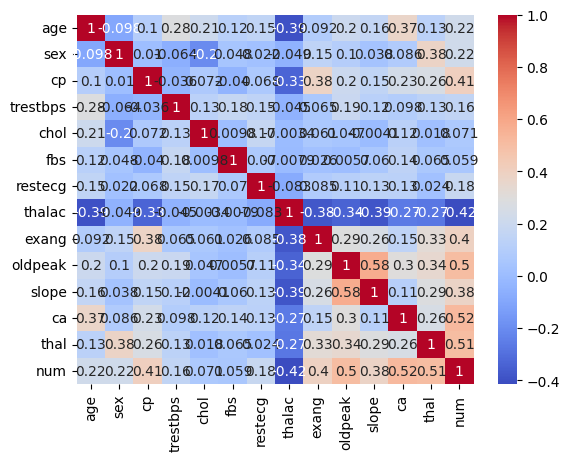

In [ ]:
# Show heatmap
corr = df.corr(numeric_only = True)
sns.heatmap(corr, annot = True, cmap = 'coolwarm')
plt.show()

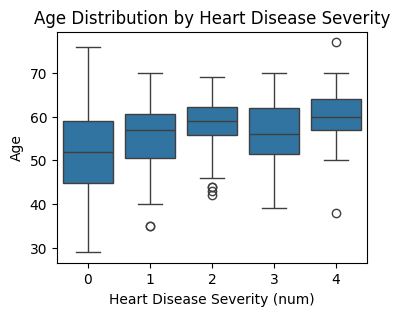

In [ ]:
# num vs age

plt.figure(figsize = (4, 3))
sns.boxplot(x = num, y = age, data = df)
plt.xlabel('Heart Disease Severity (num)')
plt.ylabel('Age')
plt.title('Age Distribution by Heart Disease Severity')
plt.show()

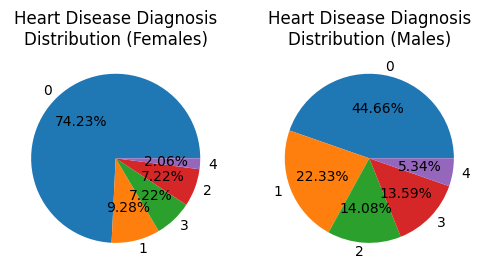

In [ ]:
# num vs sex

female_data = df[sex == 0]
male_data = df[sex == 1]

female_counts = female_data['num'].value_counts()
male_counts = male_data['num'].value_counts()

fig, axes = plt.subplots(1, 2, figsize = (6, 3))

axes[0].pie(female_counts, labels = female_counts.index, autopct = '%.2f%%')
axes[0].set_title('Heart Disease Diagnosis\nDistribution (Females)')

axes[1].pie(male_counts, labels = male_counts.index, autopct = '%.2f%%')
axes[1].set_title('Heart Disease Diagnosis\nDistribution (Males)')

plt.show()

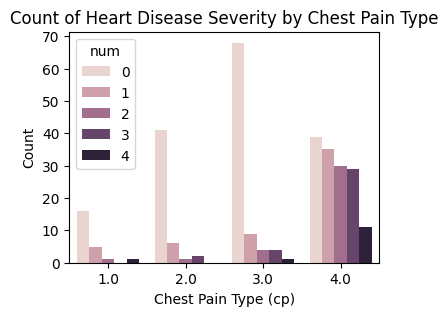

In [ ]:
# num vs cp

plt.figure(figsize = (4, 3))
sns.countplot(x = cp, hue = num, data = df)
plt.xlabel('Chest Pain Type (cp)')
plt.ylabel('Count')
plt.title('Count of Heart Disease Severity by Chest Pain Type')
plt.show()

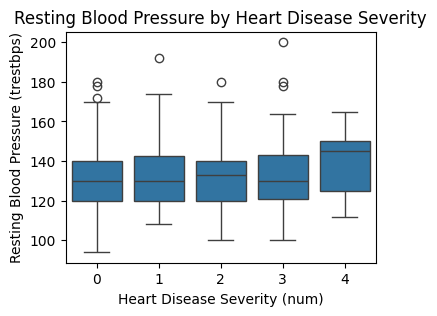

In [ ]:
# num vs trestbps

plt.figure(figsize = (4, 3))
sns.boxplot(x = num, y = trestbps, data = df)
plt.xlabel('Heart Disease Severity (num)')
plt.ylabel('Resting Blood Pressure (trestbps)')
plt.title('Resting Blood Pressure by Heart Disease Severity')
plt.show()

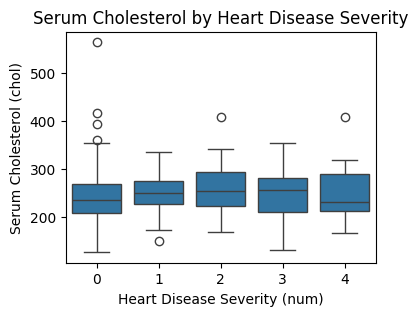

In [ ]:
# num vs chol

plt.figure(figsize = (4, 3))
sns.boxplot(x = num, y = chol, data = df)
plt.xlabel('Heart Disease Severity (num)')
plt.ylabel('Serum Cholesterol (chol)')
plt.title('Serum Cholesterol by Heart Disease Severity')
plt.show()

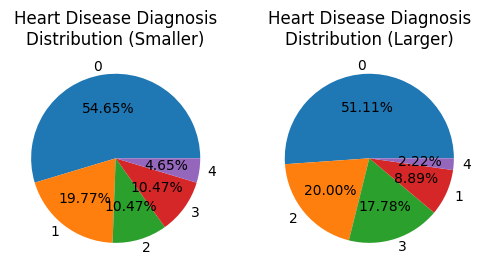

In [ ]:
# num vs fbs

smaller_data = df[fbs == 0]
larger_data = df[fbs == 1]

smaller_counts = smaller_data['num'].value_counts()
larger_counts = larger_data['num'].value_counts()

fig, axes = plt.subplots(1, 2, figsize = (6, 3))

axes[0].pie(smaller_counts, labels = smaller_counts.index, autopct = '%.2f%%')
axes[0].set_title('Heart Disease Diagnosis\nDistribution (Smaller)')

axes[1].pie(larger_counts, labels = larger_counts.index, autopct = '%.2f%%')
axes[1].set_title('Heart Disease Diagnosis\nDistribution (Larger)')

plt.show()

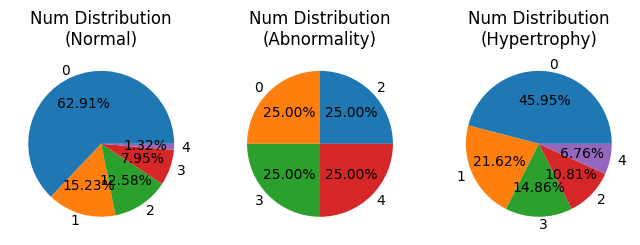

In [ ]:
# num vs restecg

normal_data = df[restecg == 0]
abnormality_data = df[restecg == 1]
hypertrophy_data = df[restecg == 2]

normal_counts = normal_data['num'].value_counts()
abnormality_counts = abnormality_data['num'].value_counts()
hypertrophy_counts = hypertrophy_data['num'].value_counts()

fig, axes = plt.subplots(1, 3, figsize = (8, 4))

axes[0].pie(normal_counts, labels = normal_counts.index, autopct = '%.2f%%')
axes[0].set_title('Num Distribution\n(Normal)')

axes[1].pie(abnormality_counts, labels = abnormality_counts.index, autopct = '%.2f%%')
axes[1].set_title('Num Distribution\n(Abnormality)')

axes[2].pie(hypertrophy_counts, labels = hypertrophy_counts.index, autopct = '%.2f%%')
axes[2].set_title('Num Distribution\n(Hypertrophy)')

plt.show()

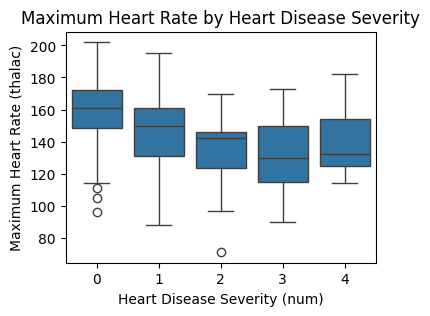

In [ ]:
# num vs thalac

plt.figure(figsize = (4, 3))
sns.boxplot(x = num, y = thalac, data = df)
plt.xlabel('Heart Disease Severity (num)')
plt.ylabel('Maximum Heart Rate (thalac)')
plt.title('Maximum Heart Rate by Heart Disease Severity')
plt.show()

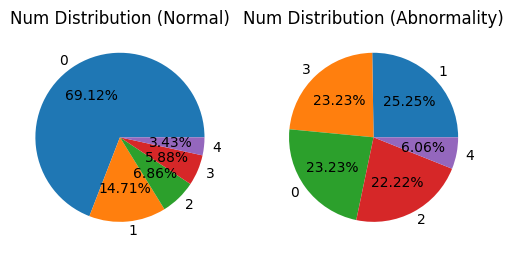

In [ ]:
# num vs exang

yes_data = df[exang == 0]
no_data = df[exang == 1]

yes_counts = yes_data['num'].value_counts()
no_counts = no_data['num'].value_counts()

fig, axes = plt.subplots(1, 2, figsize = (6, 3))

axes[0].pie(yes_counts, labels = yes_counts.index, autopct = '%.2f%%')
axes[0].set_title('Num Distribution (Normal)')

axes[1].pie(no_counts, labels = no_counts.index, autopct = '%.2f%%')
axes[1].set_title('Num Distribution (Abnormality)')

plt.show()

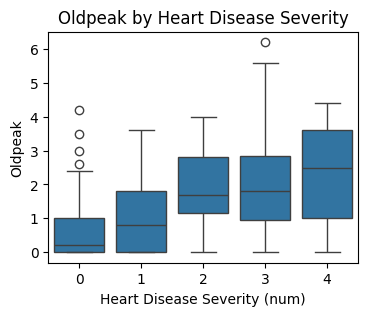

In [ ]:
# num vs oldpeak

plt.figure(figsize = (4, 3))
sns.boxplot(x = num, y = oldpeak, data = df)
plt.xlabel('Heart Disease Severity (num)')
plt.ylabel('Oldpeak')
plt.title('Oldpeak by Heart Disease Severity')
plt.show()

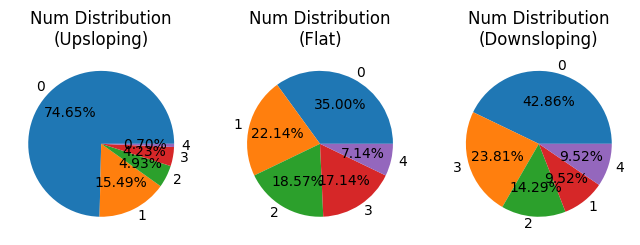

In [ ]:
# num vs slope

upsloping_data = df[slope == 1]
flat_data = df[slope == 2]
downsloping_data = df[slope == 3]

upsloping_counts = upsloping_data['num'].value_counts()
flat_counts = flat_data['num'].value_counts()
downsloping_counts = downsloping_data['num'].value_counts()

fig, axes = plt.subplots(1, 3, figsize = (8, 4))

axes[0].pie(upsloping_counts, labels = upsloping_counts.index, autopct = '%.2f%%')
axes[0].set_title('Num Distribution\n(Upsloping)')

axes[1].pie(flat_counts, labels = flat_counts.index, autopct = '%.2f%%')
axes[1].set_title('Num Distribution\n(Flat)')

axes[2].pie(downsloping_counts, labels = downsloping_counts.index, autopct = '%.2f%%')
axes[2].set_title('Num Distribution\n(Downsloping)')

plt.show()

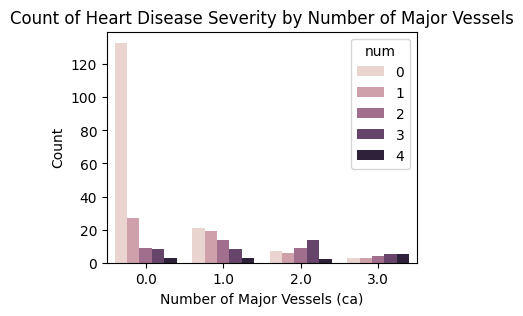

In [ ]:
# num vs ca

plt.figure(figsize = (4, 3))
sns.countplot(x = ca, hue = num, data = df)
plt.xlabel('Number of Major Vessels (ca)')
plt.ylabel('Count')
plt.title('Count of Heart Disease Severity by Number of Major Vessels')
plt.show()

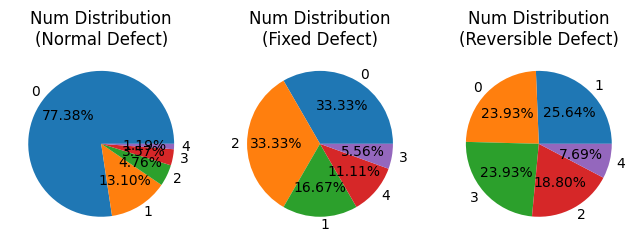

In [ ]:
# num vs thal

normaldefect_data = df[thal == 3]
fixed_data = df[thal == 6]
reversable_data = df[thal == 7]

normaldefect_counts = normaldefect_data['num'].value_counts()
fixed_counts = fixed_data['num'].value_counts()
reversable_counts = reversable_data['num'].value_counts()

fig, axes = plt.subplots(1, 3, figsize = (8, 4))

axes[0].pie(normaldefect_counts, labels = normaldefect_counts.index, autopct = '%.2f%%')
axes[0].set_title('Num Distribution\n(Normal Defect)')

axes[1].pie(fixed_counts, labels = fixed_counts.index, autopct = '%.2f%%')
axes[1].set_title('Num Distribution\n(Fixed Defect)')

axes[2].pie(reversable_counts, labels = reversable_counts.index, autopct = '%.2f%%')
axes[2].set_title('Num Distribution\n(Reversible Defect)')

plt.show()

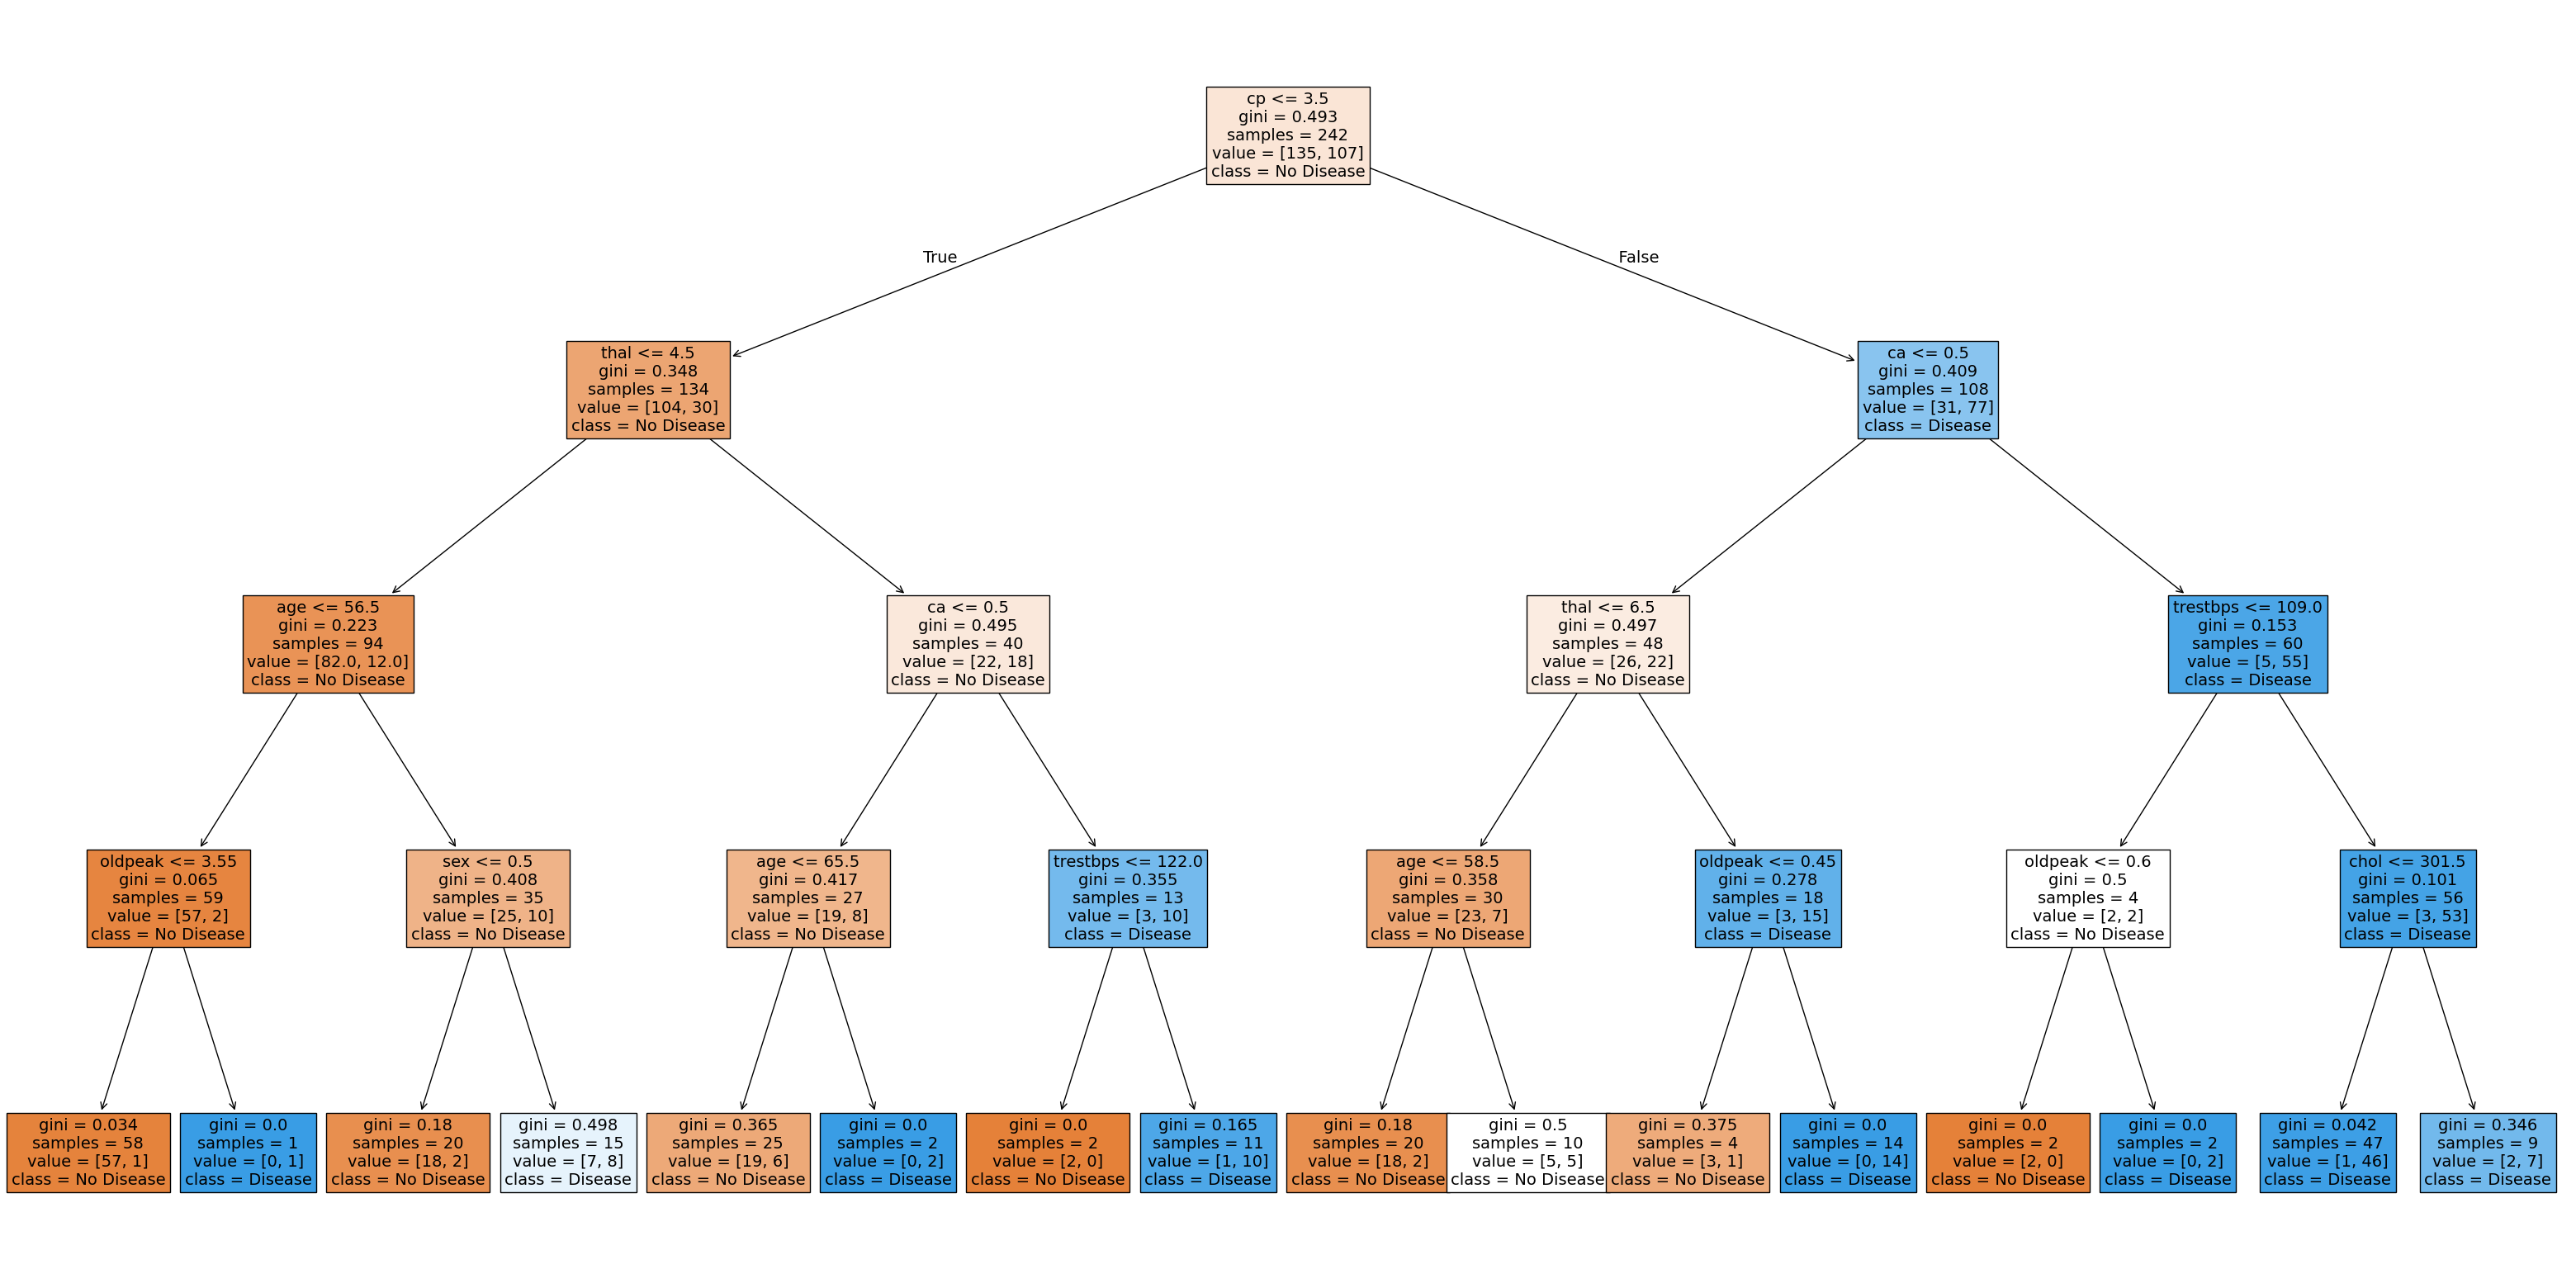

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

X = df.drop(['num'], axis=1)
y = (df['num'] > 0).astype(int)  # Binary classification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

tree = DecisionTreeClassifier(max_depth = 4, random_state = 42)
tree.fit(X_train, y_train)

plt.figure(figsize = (40, 20))
plot_tree(tree, feature_names = X.columns, class_names = ['No Disease', 'Disease'], filled = True, fontsize = 14)
plt.show()

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



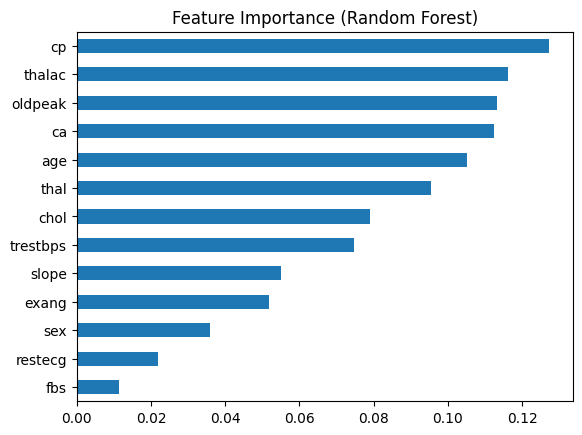

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print(classification_report(y_test, y_pred))

importances = pd.Series(forest.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh')
plt.title('Feature Importance (Random Forest)')
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:30:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.83      0.86      0.85        29
           1       0.87      0.84      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



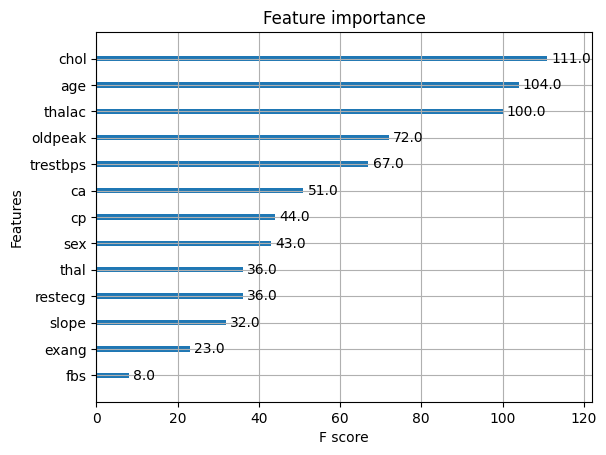

In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state = 42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

xgb.plot_importance(model)
plt.show()